# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN_DEFAULT" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/TB_CATB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/IB_CATB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LdrGetProcedureAddress,LookupAccountSidW,LdrGetProcedureAddress,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress
1,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
3,0,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile
4,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,OleInitialize,FindResourceExW,LoadResource,FindResourceExW,LoadResource


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = "Outputs/"+MODEL_FILENAME+"_"+TYPE+"_CATB_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()))
end_time("TB_CATB")

#Saving Model as file
tb_catb.save_model("Outputs/"+MODEL_FILENAME+"_TB_CATB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.084849
0:	learn: 0.5324070	test: 0.5319136	best: 0.5319136 (0)	total: 861ms	remaining: 14m 20s
1:	learn: 0.4186759	test: 0.4173287	best: 0.4173287 (1)	total: 1.48s	remaining: 12m 16s
2:	learn: 0.3037705	test: 0.3024444	best: 0.3024444 (2)	total: 2.27s	remaining: 12m 33s
3:	learn: 0.2218600	test: 0.2208919	best: 0.2208919 (3)	total: 2.94s	remaining: 12m 12s
4:	learn: 0.1735219	test: 0.1726762	best: 0.1726762 (4)	total: 3.58s	remaining: 11m 51s
5:	learn: 0.1373329	test: 0.1366019	best: 0.1366019 (5)	total: 4.26s	remaining: 11m 45s
6:	learn: 0.1075913	test: 0.1071419	best: 0.1071419 (6)	total: 5.05s	remaining: 11m 56s
7:	learn: 0.0873824	test: 0.0872055	best: 0.0872055 (7)	total: 5.84s	remaining: 12m 3s
8:	learn: 0.0729376	test: 0.0731425	best: 0.0731425 (8)	total: 6.72s	remaining: 12m 20s
9:	learn: 0.0626074	test: 0.0630757	best: 0.0630757 (9)	total: 7.84s	remaining: 12m 55s
10:	learn: 0.0547452	test: 0.0554028	best: 0.0554028 (10)	total: 8.69s	remaining: 13m 1s
11

92:	learn: 0.0154828	test: 0.0206293	best: 0.0206283 (91)	total: 1m 21s	remaining: 13m 19s
93:	learn: 0.0154097	test: 0.0205981	best: 0.0205981 (93)	total: 1m 23s	remaining: 13m 21s
94:	learn: 0.0153303	test: 0.0205606	best: 0.0205606 (94)	total: 1m 24s	remaining: 13m 21s
95:	learn: 0.0152916	test: 0.0205481	best: 0.0205481 (95)	total: 1m 24s	remaining: 13m 19s
96:	learn: 0.0151857	test: 0.0204962	best: 0.0204962 (96)	total: 1m 25s	remaining: 13m 19s
97:	learn: 0.0151094	test: 0.0204725	best: 0.0204725 (97)	total: 1m 26s	remaining: 13m 17s
98:	learn: 0.0150326	test: 0.0204466	best: 0.0204466 (98)	total: 1m 27s	remaining: 13m 16s
99:	learn: 0.0149393	test: 0.0204217	best: 0.0204217 (99)	total: 1m 28s	remaining: 13m 14s
100:	learn: 0.0148896	test: 0.0203943	best: 0.0203943 (100)	total: 1m 29s	remaining: 13m 12s
101:	learn: 0.0147993	test: 0.0203380	best: 0.0203380 (101)	total: 1m 29s	remaining: 13m 11s
102:	learn: 0.0147285	test: 0.0203202	best: 0.0203202 (102)	total: 1m 30s	remaining: 1

181:	learn: 0.0110132	test: 0.0191039	best: 0.0191039 (181)	total: 2m 37s	remaining: 11m 45s
182:	learn: 0.0109767	test: 0.0190953	best: 0.0190953 (182)	total: 2m 37s	remaining: 11m 44s
183:	learn: 0.0109505	test: 0.0190870	best: 0.0190870 (183)	total: 2m 38s	remaining: 11m 43s
184:	learn: 0.0109030	test: 0.0190731	best: 0.0190731 (184)	total: 2m 39s	remaining: 11m 43s
185:	learn: 0.0108590	test: 0.0190530	best: 0.0190530 (185)	total: 2m 40s	remaining: 11m 42s
186:	learn: 0.0108245	test: 0.0190501	best: 0.0190501 (186)	total: 2m 41s	remaining: 11m 41s
187:	learn: 0.0107733	test: 0.0189966	best: 0.0189966 (187)	total: 2m 42s	remaining: 11m 40s
188:	learn: 0.0107373	test: 0.0189914	best: 0.0189914 (188)	total: 2m 42s	remaining: 11m 39s
189:	learn: 0.0107077	test: 0.0189821	best: 0.0189821 (189)	total: 2m 43s	remaining: 11m 38s
190:	learn: 0.0106815	test: 0.0189673	best: 0.0189673 (190)	total: 2m 44s	remaining: 11m 37s
191:	learn: 0.0106738	test: 0.0189657	best: 0.0189657 (191)	total: 2m 

270:	learn: 0.0085250	test: 0.0182704	best: 0.0182601 (267)	total: 3m 51s	remaining: 10m 22s
271:	learn: 0.0085083	test: 0.0182718	best: 0.0182601 (267)	total: 3m 52s	remaining: 10m 21s
272:	learn: 0.0084949	test: 0.0182645	best: 0.0182601 (267)	total: 3m 53s	remaining: 10m 20s
273:	learn: 0.0084855	test: 0.0182727	best: 0.0182601 (267)	total: 3m 53s	remaining: 10m 19s
274:	learn: 0.0084611	test: 0.0182686	best: 0.0182601 (267)	total: 3m 54s	remaining: 10m 18s
275:	learn: 0.0084522	test: 0.0182763	best: 0.0182601 (267)	total: 3m 55s	remaining: 10m 18s
276:	learn: 0.0084176	test: 0.0182475	best: 0.0182475 (276)	total: 3m 56s	remaining: 10m 16s
277:	learn: 0.0083971	test: 0.0182260	best: 0.0182260 (277)	total: 3m 57s	remaining: 10m 15s
278:	learn: 0.0083839	test: 0.0182233	best: 0.0182233 (278)	total: 3m 58s	remaining: 10m 15s
279:	learn: 0.0083500	test: 0.0182218	best: 0.0182218 (279)	total: 3m 59s	remaining: 10m 14s
280:	learn: 0.0083178	test: 0.0182061	best: 0.0182061 (280)	total: 3m 

360:	learn: 0.0068448	test: 0.0178804	best: 0.0178755 (359)	total: 5m 7s	remaining: 9m 3s
361:	learn: 0.0068448	test: 0.0178804	best: 0.0178755 (359)	total: 5m 7s	remaining: 9m 2s
362:	learn: 0.0068448	test: 0.0178803	best: 0.0178755 (359)	total: 5m 8s	remaining: 9m 1s
363:	learn: 0.0068447	test: 0.0178803	best: 0.0178755 (359)	total: 5m 9s	remaining: 9m
364:	learn: 0.0068333	test: 0.0178798	best: 0.0178755 (359)	total: 5m 10s	remaining: 8m 59s
365:	learn: 0.0068220	test: 0.0178734	best: 0.0178734 (365)	total: 5m 11s	remaining: 8m 58s
366:	learn: 0.0068219	test: 0.0178734	best: 0.0178734 (366)	total: 5m 11s	remaining: 8m 57s
367:	learn: 0.0068113	test: 0.0178676	best: 0.0178676 (367)	total: 5m 12s	remaining: 8m 57s
368:	learn: 0.0068113	test: 0.0178676	best: 0.0178676 (368)	total: 5m 13s	remaining: 8m 56s
369:	learn: 0.0067968	test: 0.0178568	best: 0.0178568 (369)	total: 5m 14s	remaining: 8m 55s
370:	learn: 0.0067646	test: 0.0178626	best: 0.0178568 (369)	total: 5m 15s	remaining: 8m 54s

450:	learn: 0.0057733	test: 0.0177611	best: 0.0177603 (449)	total: 6m 24s	remaining: 7m 47s
451:	learn: 0.0057639	test: 0.0177544	best: 0.0177544 (451)	total: 6m 24s	remaining: 7m 46s
452:	learn: 0.0057638	test: 0.0177544	best: 0.0177544 (452)	total: 6m 25s	remaining: 7m 45s
453:	learn: 0.0057638	test: 0.0177544	best: 0.0177544 (453)	total: 6m 26s	remaining: 7m 44s
454:	learn: 0.0057638	test: 0.0177544	best: 0.0177544 (453)	total: 6m 27s	remaining: 7m 44s
455:	learn: 0.0057638	test: 0.0177544	best: 0.0177544 (453)	total: 6m 28s	remaining: 7m 43s
456:	learn: 0.0057638	test: 0.0177544	best: 0.0177544 (453)	total: 6m 29s	remaining: 7m 42s
457:	learn: 0.0057638	test: 0.0177544	best: 0.0177544 (453)	total: 6m 30s	remaining: 7m 41s
458:	learn: 0.0057544	test: 0.0177606	best: 0.0177544 (453)	total: 6m 30s	remaining: 7m 40s
459:	learn: 0.0057378	test: 0.0177567	best: 0.0177544 (453)	total: 6m 31s	remaining: 7m 39s
460:	learn: 0.0057135	test: 0.0177676	best: 0.0177544 (453)	total: 6m 32s	remain

540:	learn: 0.0053529	test: 0.0177996	best: 0.0177544 (453)	total: 7m 41s	remaining: 6m 31s
541:	learn: 0.0053529	test: 0.0177996	best: 0.0177544 (453)	total: 7m 42s	remaining: 6m 30s
542:	learn: 0.0053529	test: 0.0177995	best: 0.0177544 (453)	total: 7m 42s	remaining: 6m 29s
543:	learn: 0.0053529	test: 0.0177995	best: 0.0177544 (453)	total: 7m 43s	remaining: 6m 28s
544:	learn: 0.0053498	test: 0.0178040	best: 0.0177544 (453)	total: 7m 44s	remaining: 6m 27s
545:	learn: 0.0053498	test: 0.0178040	best: 0.0177544 (453)	total: 7m 45s	remaining: 6m 27s
546:	learn: 0.0053498	test: 0.0178040	best: 0.0177544 (453)	total: 7m 46s	remaining: 6m 26s
547:	learn: 0.0053498	test: 0.0178040	best: 0.0177544 (453)	total: 7m 47s	remaining: 6m 25s
548:	learn: 0.0053496	test: 0.0178041	best: 0.0177544 (453)	total: 7m 48s	remaining: 6m 24s
549:	learn: 0.0053496	test: 0.0178041	best: 0.0177544 (453)	total: 7m 49s	remaining: 6m 23s
550:	learn: 0.0053496	test: 0.0178041	best: 0.0177544 (453)	total: 7m 49s	remain

630:	learn: 0.0053451	test: 0.0178102	best: 0.0177544 (453)	total: 8m 58s	remaining: 5m 14s
631:	learn: 0.0053451	test: 0.0178102	best: 0.0177544 (453)	total: 8m 59s	remaining: 5m 13s
632:	learn: 0.0053451	test: 0.0178102	best: 0.0177544 (453)	total: 9m	remaining: 5m 13s
633:	learn: 0.0053451	test: 0.0178102	best: 0.0177544 (453)	total: 9m	remaining: 5m 12s
634:	learn: 0.0053145	test: 0.0178243	best: 0.0177544 (453)	total: 9m 1s	remaining: 5m 11s
635:	learn: 0.0053145	test: 0.0178242	best: 0.0177544 (453)	total: 9m 2s	remaining: 5m 10s
636:	learn: 0.0053049	test: 0.0178166	best: 0.0177544 (453)	total: 9m 3s	remaining: 5m 9s
637:	learn: 0.0053049	test: 0.0178166	best: 0.0177544 (453)	total: 9m 4s	remaining: 5m 8s
638:	learn: 0.0053049	test: 0.0178166	best: 0.0177544 (453)	total: 9m 5s	remaining: 5m 8s
639:	learn: 0.0053049	test: 0.0178166	best: 0.0177544 (453)	total: 9m 6s	remaining: 5m 7s
640:	learn: 0.0053049	test: 0.0178166	best: 0.0177544 (453)	total: 9m 6s	remaining: 5m 6s
641:	lea

720:	learn: 0.0052577	test: 0.0178012	best: 0.0177544 (453)	total: 10m 13s	remaining: 3m 57s
721:	learn: 0.0052577	test: 0.0178012	best: 0.0177544 (453)	total: 10m 14s	remaining: 3m 56s
722:	learn: 0.0052577	test: 0.0178012	best: 0.0177544 (453)	total: 10m 15s	remaining: 3m 55s
723:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m 16s	remaining: 3m 54s
724:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m 16s	remaining: 3m 53s
725:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m 17s	remaining: 3m 53s
726:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m 18s	remaining: 3m 52s
727:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m 19s	remaining: 3m 51s
728:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m 19s	remaining: 3m 50s
729:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m 20s	remaining: 3m 49s
730:	learn: 0.0052577	test: 0.0178013	best: 0.0177544 (453)	total: 10m

809:	learn: 0.0052566	test: 0.0178025	best: 0.0177544 (453)	total: 11m 26s	remaining: 2m 40s
810:	learn: 0.0052566	test: 0.0178025	best: 0.0177544 (453)	total: 11m 26s	remaining: 2m 40s
811:	learn: 0.0052566	test: 0.0178025	best: 0.0177544 (453)	total: 11m 27s	remaining: 2m 39s
812:	learn: 0.0052566	test: 0.0178025	best: 0.0177544 (453)	total: 11m 28s	remaining: 2m 38s
813:	learn: 0.0052565	test: 0.0178025	best: 0.0177544 (453)	total: 11m 29s	remaining: 2m 37s
814:	learn: 0.0052565	test: 0.0178025	best: 0.0177544 (453)	total: 11m 30s	remaining: 2m 36s
815:	learn: 0.0052565	test: 0.0178026	best: 0.0177544 (453)	total: 11m 31s	remaining: 2m 35s
816:	learn: 0.0052565	test: 0.0178026	best: 0.0177544 (453)	total: 11m 32s	remaining: 2m 35s
817:	learn: 0.0052565	test: 0.0178026	best: 0.0177544 (453)	total: 11m 32s	remaining: 2m 34s
818:	learn: 0.0052565	test: 0.0178026	best: 0.0177544 (453)	total: 11m 33s	remaining: 2m 33s
819:	learn: 0.0052565	test: 0.0178026	best: 0.0177544 (453)	total: 11m

898:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 38s	remaining: 1m 25s
899:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 39s	remaining: 1m 24s
900:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 40s	remaining: 1m 23s
901:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 40s	remaining: 1m 22s
902:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 41s	remaining: 1m 21s
903:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 42s	remaining: 1m 20s
904:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 43s	remaining: 1m 20s
905:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 44s	remaining: 1m 19s
906:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 44s	remaining: 1m 18s
907:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m 45s	remaining: 1m 17s
908:	learn: 0.0052556	test: 0.0178035	best: 0.0177544 (453)	total: 12m

988:	learn: 0.0052550	test: 0.0178043	best: 0.0177544 (453)	total: 13m 51s	remaining: 9.25s
989:	learn: 0.0052550	test: 0.0178043	best: 0.0177544 (453)	total: 13m 52s	remaining: 8.41s
990:	learn: 0.0052549	test: 0.0178043	best: 0.0177544 (453)	total: 13m 53s	remaining: 7.57s
991:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 54s	remaining: 6.73s
992:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 55s	remaining: 5.89s
993:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 55s	remaining: 5.04s
994:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 56s	remaining: 4.2s
995:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 57s	remaining: 3.36s
996:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 58s	remaining: 2.52s
997:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 58s	remaining: 1.68s
998:	learn: 0.0052549	test: 0.0178044	best: 0.0177544 (453)	total: 13m 59s	remain

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [11]:
print(classification_report(y_tb_validate, tb_catb.predict(X_tb_validate),digits=4))

              precision    recall  f1-score   support

           0     0.9983    0.9911    0.9947     11470
           1     0.9913    0.9984    0.9948     11638

    accuracy                         0.9948     23108
   macro avg     0.9948    0.9947    0.9948     23108
weighted avg     0.9948    0.9948    0.9948     23108



### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

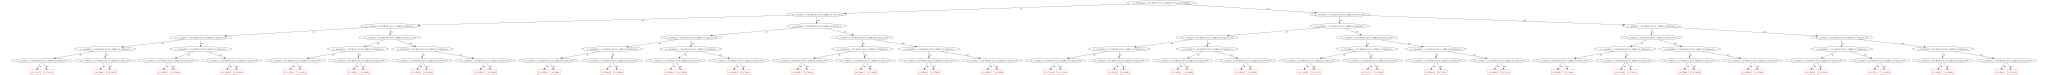

In [12]:
tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/"+MODEL_FILENAME+"_CATB/TB_Tree"+".svg")
tree

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()))
end_time("TB_CATB")
end_time("IB_CATB")

#Saving Model as file
ib_catb.save_model("Outputs/"+MODEL_FILENAME+"_IB_CATB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.084849
0:	learn: 0.5528063	test: 0.5528146	best: 0.5528146 (0)	total: 341ms	remaining: 5m 40s
1:	learn: 0.4144330	test: 0.4148352	best: 0.4148352 (1)	total: 628ms	remaining: 5m 13s
2:	learn: 0.2981296	test: 0.2982494	best: 0.2982494 (2)	total: 942ms	remaining: 5m 13s
3:	learn: 0.2174585	test: 0.2173435	best: 0.2173435 (3)	total: 1.27s	remaining: 5m 15s
4:	learn: 0.1590827	test: 0.1592384	best: 0.1592384 (4)	total: 1.62s	remaining: 5m 23s
5:	learn: 0.1243309	test: 0.1244735	best: 0.1244735 (5)	total: 1.98s	remaining: 5m 28s
6:	learn: 0.0970030	test: 0.0971294	best: 0.0971294 (6)	total: 2.4s	remaining: 5m 41s
7:	learn: 0.0813320	test: 0.0814089	best: 0.0814089 (7)	total: 2.75s	remaining: 5m 41s
8:	learn: 0.0687811	test: 0.0690853	best: 0.0690853 (8)	total: 3.13s	remaining: 5m 44s
9:	learn: 0.0601289	test: 0.0604416	best: 0.0604416 (9)	total: 3.52s	remaining: 5m 48s
10:	learn: 0.0529101	test: 0.0534530	best: 0.0534530 (10)	total: 3.85s	remaining: 5m 45s
11:	learn: 0

93:	learn: 0.0180402	test: 0.0211425	best: 0.0211425 (93)	total: 33.2s	remaining: 5m 19s
94:	learn: 0.0179418	test: 0.0209871	best: 0.0209871 (94)	total: 33.6s	remaining: 5m 19s
95:	learn: 0.0178798	test: 0.0209635	best: 0.0209635 (95)	total: 34.1s	remaining: 5m 20s
96:	learn: 0.0178533	test: 0.0209436	best: 0.0209436 (96)	total: 34.4s	remaining: 5m 20s
97:	learn: 0.0178038	test: 0.0209115	best: 0.0209115 (97)	total: 34.9s	remaining: 5m 20s
98:	learn: 0.0177385	test: 0.0208682	best: 0.0208682 (98)	total: 35.2s	remaining: 5m 20s
99:	learn: 0.0177261	test: 0.0208660	best: 0.0208660 (99)	total: 35.7s	remaining: 5m 20s
100:	learn: 0.0177260	test: 0.0208659	best: 0.0208659 (100)	total: 36s	remaining: 5m 20s
101:	learn: 0.0177098	test: 0.0208474	best: 0.0208474 (101)	total: 36.5s	remaining: 5m 21s
102:	learn: 0.0175897	test: 0.0207325	best: 0.0207325 (102)	total: 37s	remaining: 5m 22s
103:	learn: 0.0174963	test: 0.0206894	best: 0.0206894 (103)	total: 37.4s	remaining: 5m 22s
104:	learn: 0.017

184:	learn: 0.0154353	test: 0.0194531	best: 0.0194531 (184)	total: 1m 5s	remaining: 4m 50s
185:	learn: 0.0153897	test: 0.0194463	best: 0.0194463 (185)	total: 1m 6s	remaining: 4m 49s
186:	learn: 0.0153659	test: 0.0194316	best: 0.0194316 (186)	total: 1m 6s	remaining: 4m 49s
187:	learn: 0.0153659	test: 0.0194316	best: 0.0194316 (187)	total: 1m 6s	remaining: 4m 48s
188:	learn: 0.0153659	test: 0.0194316	best: 0.0194316 (188)	total: 1m 7s	remaining: 4m 47s
189:	learn: 0.0153209	test: 0.0194118	best: 0.0194118 (189)	total: 1m 7s	remaining: 4m 47s
190:	learn: 0.0153209	test: 0.0194118	best: 0.0194118 (190)	total: 1m 7s	remaining: 4m 46s
191:	learn: 0.0153064	test: 0.0194078	best: 0.0194078 (191)	total: 1m 8s	remaining: 4m 46s
192:	learn: 0.0152754	test: 0.0193969	best: 0.0193969 (192)	total: 1m 8s	remaining: 4m 46s
193:	learn: 0.0152754	test: 0.0193969	best: 0.0193969 (193)	total: 1m 8s	remaining: 4m 45s
194:	learn: 0.0152484	test: 0.0193962	best: 0.0193962 (194)	total: 1m 9s	remaining: 4m 45s

274:	learn: 0.0148352	test: 0.0192237	best: 0.0192237 (262)	total: 1m 30s	remaining: 3m 58s
275:	learn: 0.0148352	test: 0.0192237	best: 0.0192237 (262)	total: 1m 30s	remaining: 3m 58s
276:	learn: 0.0148352	test: 0.0192237	best: 0.0192237 (276)	total: 1m 30s	remaining: 3m 57s
277:	learn: 0.0148352	test: 0.0192237	best: 0.0192237 (276)	total: 1m 31s	remaining: 3m 57s
278:	learn: 0.0148352	test: 0.0192237	best: 0.0192237 (276)	total: 1m 31s	remaining: 3m 56s
279:	learn: 0.0148352	test: 0.0192237	best: 0.0192237 (276)	total: 1m 31s	remaining: 3m 56s
280:	learn: 0.0148352	test: 0.0192237	best: 0.0192237 (276)	total: 1m 32s	remaining: 3m 56s
281:	learn: 0.0148352	test: 0.0192236	best: 0.0192236 (281)	total: 1m 32s	remaining: 3m 55s
282:	learn: 0.0148352	test: 0.0192236	best: 0.0192236 (281)	total: 1m 32s	remaining: 3m 54s
283:	learn: 0.0148352	test: 0.0192236	best: 0.0192236 (281)	total: 1m 32s	remaining: 3m 54s
284:	learn: 0.0148352	test: 0.0192236	best: 0.0192236 (281)	total: 1m 33s	remain

364:	learn: 0.0148347	test: 0.0192220	best: 0.0192220 (363)	total: 1m 54s	remaining: 3m 18s
365:	learn: 0.0148347	test: 0.0192220	best: 0.0192220 (365)	total: 1m 54s	remaining: 3m 18s
366:	learn: 0.0148347	test: 0.0192220	best: 0.0192220 (365)	total: 1m 54s	remaining: 3m 18s
367:	learn: 0.0148347	test: 0.0192220	best: 0.0192220 (367)	total: 1m 55s	remaining: 3m 17s
368:	learn: 0.0148347	test: 0.0192220	best: 0.0192220 (368)	total: 1m 55s	remaining: 3m 17s
369:	learn: 0.0148347	test: 0.0192220	best: 0.0192220 (369)	total: 1m 55s	remaining: 3m 16s
370:	learn: 0.0148347	test: 0.0192219	best: 0.0192219 (370)	total: 1m 55s	remaining: 3m 16s
371:	learn: 0.0148347	test: 0.0192219	best: 0.0192219 (370)	total: 1m 56s	remaining: 3m 16s
372:	learn: 0.0148347	test: 0.0192219	best: 0.0192219 (372)	total: 1m 56s	remaining: 3m 15s
373:	learn: 0.0148347	test: 0.0192219	best: 0.0192219 (373)	total: 1m 56s	remaining: 3m 15s
374:	learn: 0.0148346	test: 0.0192218	best: 0.0192218 (374)	total: 1m 56s	remain

454:	learn: 0.0137223	test: 0.0187631	best: 0.0187631 (454)	total: 2m 20s	remaining: 2m 48s
455:	learn: 0.0137223	test: 0.0187631	best: 0.0187631 (454)	total: 2m 20s	remaining: 2m 47s
456:	learn: 0.0137223	test: 0.0187631	best: 0.0187631 (456)	total: 2m 20s	remaining: 2m 47s
457:	learn: 0.0137223	test: 0.0187631	best: 0.0187631 (457)	total: 2m 21s	remaining: 2m 46s
458:	learn: 0.0137222	test: 0.0187631	best: 0.0187631 (458)	total: 2m 21s	remaining: 2m 46s
459:	learn: 0.0137222	test: 0.0187630	best: 0.0187630 (459)	total: 2m 21s	remaining: 2m 46s
460:	learn: 0.0137004	test: 0.0187694	best: 0.0187630 (459)	total: 2m 22s	remaining: 2m 46s
461:	learn: 0.0136990	test: 0.0187692	best: 0.0187630 (459)	total: 2m 22s	remaining: 2m 45s
462:	learn: 0.0136844	test: 0.0187416	best: 0.0187416 (462)	total: 2m 22s	remaining: 2m 45s
463:	learn: 0.0136732	test: 0.0187162	best: 0.0187162 (463)	total: 2m 23s	remaining: 2m 45s
464:	learn: 0.0136621	test: 0.0186945	best: 0.0186945 (464)	total: 2m 23s	remain

544:	learn: 0.0128830	test: 0.0183445	best: 0.0183369 (541)	total: 2m 50s	remaining: 2m 22s
545:	learn: 0.0128830	test: 0.0183445	best: 0.0183369 (541)	total: 2m 50s	remaining: 2m 21s
546:	learn: 0.0128830	test: 0.0183445	best: 0.0183369 (541)	total: 2m 50s	remaining: 2m 21s
547:	learn: 0.0128830	test: 0.0183445	best: 0.0183369 (541)	total: 2m 51s	remaining: 2m 21s
548:	learn: 0.0128830	test: 0.0183445	best: 0.0183369 (541)	total: 2m 51s	remaining: 2m 20s
549:	learn: 0.0128830	test: 0.0183445	best: 0.0183369 (541)	total: 2m 51s	remaining: 2m 20s
550:	learn: 0.0128441	test: 0.0183005	best: 0.0183005 (550)	total: 2m 52s	remaining: 2m 20s
551:	learn: 0.0128138	test: 0.0183003	best: 0.0183003 (551)	total: 2m 52s	remaining: 2m 20s
552:	learn: 0.0127970	test: 0.0182872	best: 0.0182872 (552)	total: 2m 52s	remaining: 2m 19s
553:	learn: 0.0127970	test: 0.0182871	best: 0.0182871 (553)	total: 2m 53s	remaining: 2m 19s
554:	learn: 0.0127578	test: 0.0182573	best: 0.0182573 (554)	total: 2m 53s	remain

634:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 19s	remaining: 1m 54s
635:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 20s	remaining: 1m 54s
636:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 20s	remaining: 1m 54s
637:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 20s	remaining: 1m 53s
638:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 21s	remaining: 1m 53s
639:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 21s	remaining: 1m 53s
640:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 21s	remaining: 1m 53s
641:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 22s	remaining: 1m 52s
642:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 22s	remaining: 1m 52s
643:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 23s	remaining: 1m 52s
644:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 23s	remain

726:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 46s	remaining: 1m 25s
727:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 47s	remaining: 1m 24s
728:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 47s	remaining: 1m 24s
729:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 47s	remaining: 1m 24s
730:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 48s	remaining: 1m 24s
731:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 48s	remaining: 1m 23s
732:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 48s	remaining: 1m 23s
733:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 49s	remaining: 1m 23s
734:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 49s	remaining: 1m 22s
735:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 50s	remaining: 1m 22s
736:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 3m 50s	remain

818:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 17s	remaining: 56.9s
819:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 17s	remaining: 56.6s
820:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 18s	remaining: 56.3s
821:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 18s	remaining: 55.9s
822:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 18s	remaining: 55.6s
823:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 18s	remaining: 55.3s
824:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 19s	remaining: 54.9s
825:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 19s	remaining: 54.7s
826:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 19s	remaining: 54.4s
827:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 19s	remaining: 54s
828:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 20s	remaining: 53.6s
8

909:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 44s	remaining: 28.1s
910:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 44s	remaining: 27.8s
911:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 44s	remaining: 27.5s
912:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 45s	remaining: 27.2s
913:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 45s	remaining: 26.8s
914:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 45s	remaining: 26.5s
915:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 45s	remaining: 26.2s
916:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 46s	remaining: 25.9s
917:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 46s	remaining: 25.6s
918:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 46s	remaining: 25.3s
919:	learn: 0.0122420	test: 0.0181168	best: 0.0181168 (631)	total: 4m 47s	remaining: 25s
9

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [14]:
print(classification_report(y_ib_validate, ib_catb.predict(X_ib_validate),digits=4))

              precision    recall  f1-score   support

           0     0.9977    0.9917    0.9947     11526
           1     0.9918    0.9978    0.9947     11582

    accuracy                         0.9947     23108
   macro avg     0.9947    0.9947    0.9947     23108
weighted avg     0.9947    0.9947    0.9947     23108



### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

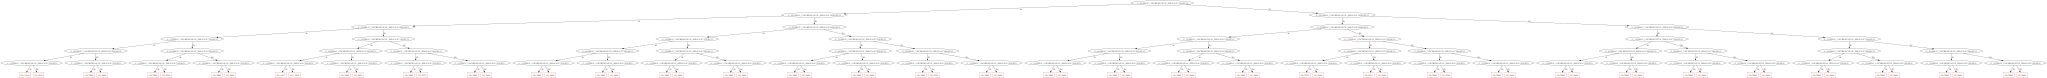

In [15]:
tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/"+MODEL_FILENAME+"_CATB/IB_Tree"+".svg")
tree

In [16]:
logging("\n")